In [7]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("medquad.csv", dtype=str, keep_default_na=False)
df.head()

,source,url,question,answer,qtype,entity,file,folder
0,CDC,http://www.cdc.gov/hantavirus/,how is hps diagnosed and treated for Hantavirus ?,Diagnosing HPS Diagnosing HPS in an individual...,treatment,,0000212.xml,9_CDC_QA
1,CDC,http://www.cdc.gov/hantavirus/,what are the symptoms for Hantavirus ?,"Due to the small number of HPS cases, the ""inc...",symptoms,,0000212.xml,9_CDC_QA
2,CDC,http://www.cdc.gov/hantavirus/,how can hps be prevented for Hantavirus ?,Eliminate or minimize contact with rodents in ...,prevention,,0000212.xml,9_CDC_QA
3,CDC,http://www.cdc.gov/hantavirus/,what is the history of hps for Hantavirus ?,"The ""First""Outbreak In May 1993, an outbreak o...",information,,0000212.xml,9_CDC_QA
4,CDC,http://www.cdc.gov/vhf/hendra/index.html,Who is at risk for Hendra Virus Disease (HeV)? ?,Transmission of Hendra virus to humans can occ...,susceptibility,,0000228.xml,9_CDC_QA


In [3]:
# Data Preprocessing
def _clean_text(x: str) -> str:
    x = x.strip()
    # collapse whitespace & newlines
    x = re.sub(r"\s+", " ", x)
    return x

# Ensure the impt cols exist as strings
for col in ["question", "answer", "qtype", "entity", "source", "url", "file", "folder"]:
    if col not in df.columns:
        df[col] = ""
    df[col] = df[col].astype(str)


# Drop rows where question/asnwer are empty after stripping, if any
df["question"] = df["question"].apply(_clean_text)
df["answer"]   = df["answer"].apply(_clean_text)
df = df[(df["question"].str.len() > 0) & (df["answer"].str.len() > 0)].copy()

# Drop duplicate pairs
df = df.drop_duplicates(subset=["question", "answer"]).reset_index(drop=True)

# Build a retrieval-ready 'doc' = reference passage to index
def build_doc(row):
    bits = [row["answer"]]
    if row["entity"]:
        bits.append(f"Entity: {row['entity']}")
    if row["qtype"]:
        bits.append(f"Type: {row['qtype']}")
    if row["source"]:
        bits.append(f"Source: {row['source']}")
    if row["url"]:
        bits.append(f"URL: {row['url']}")
    return "\n".join(bits)

df["doc"] = df.apply(build_doc, axis=1)

df["question_len"] = df["question"].str.split().apply(len)
df["answer_len"]   = df["answer"].str.split().apply(len)

print("Data rows:", len(df))

Data rows: 16363


In [6]:
# Summary statistics
print("\nSummary Statistics ")
print("\nUnique sources:", df['source'].nunique())
print("Top sources:\n", df['source'].value_counts().head(10))

print("\nUnique qtypes:", df['qtype'].nunique())
print("Top qtypes:\n", df['qtype'].value_counts())

# QA lengths
df['question_len'] = df['question'].str.len()
df['answer_len'] = df['answer'].str.len()

print("\nAverage question length:", df['question_len'].mean())
print("Average answer length:", df['answer_len'].mean())


Summary Statistics 

Unique sources: 10
Top sources:
 source
GHR                  5430
GARD                 5389
NIDDK                1144
NINDS                1088
MPlusHealthTopics     981
NIHSeniorHealth       769
CancerGov             729
NHLBI                 559
CDC                   270
                        4
Name: count, dtype: int64

Unique qtypes: 17
Top qtypes:
 qtype
information        4520
symptoms           2747
treatment          2440
inheritance        1446
frequency          1120
genetic changes    1087
causes              708
exams and tests     650
research            395
outlook             361
susceptibility      324
considerations      228
prevention          209
stages               77
complications        46
                      4
support groups        1
Name: count, dtype: int64

Average question length: 50.69272138360936
Average answer length: 1253.954653792092


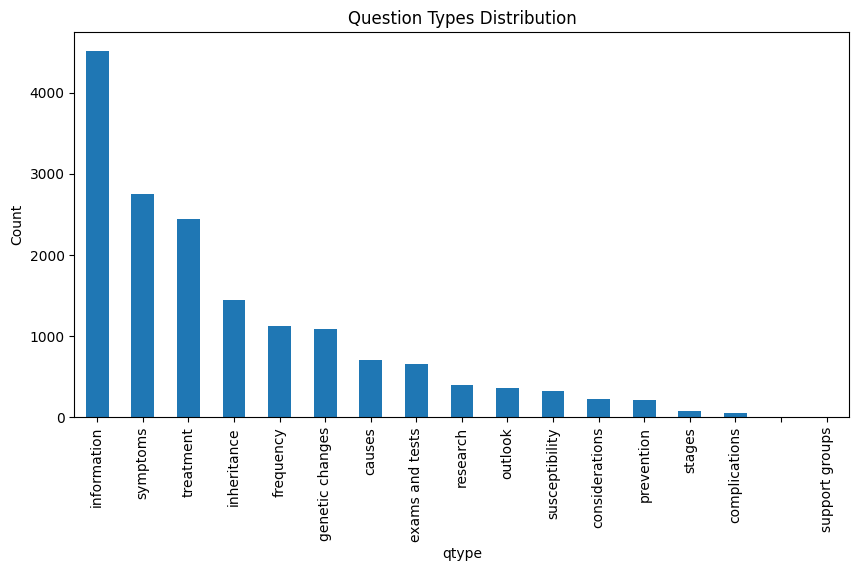

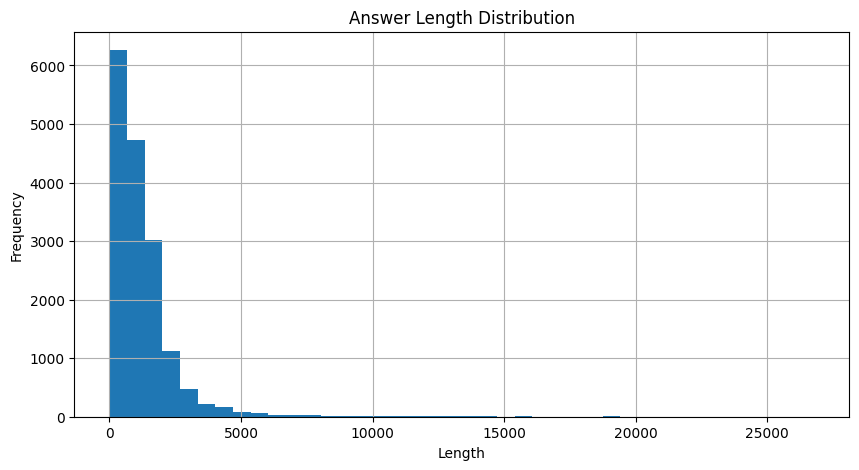

In [8]:
plt.figure(figsize=(10,5))
df['qtype'].value_counts().plot(kind='bar')
plt.title("Question Types Distribution")
plt.xlabel("qtype")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
df['answer_len'].hist(bins=40)
plt.title("Answer Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [7]:
# Stratified splits (Train/val/test = 80/10/10)
# Create a stratification label that collapses tiny classes
MIN_PER_CLASS = 5   
qtype = df.get("qtype", pd.Series([""]*len(df), index=df.index)).fillna("")

counts = qtype.value_counts()
rare = counts[counts < MIN_PER_CLASS].index

df = df.copy()
df["qtype_strat"] = qtype.where(~qtype.isin(rare), "OTHER")

# First split (80/20), with stratify on qtype_strat
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["qtype_strat"])

# Second split (10/10)
temp_counts = temp_df["qtype_strat"].value_counts()
can_strat_second = (temp_counts.min() >= 2) and (temp_df["qtype_strat"].nunique() > 1)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42,
    stratify=temp_df["qtype_strat"] if can_strat_second else None)

print("Sizes:", len(train_df), len(val_df), len(test_df))

def dist(name, s):
    print(f"\n{name} type stratified distribution:")
    print(s.value_counts(normalize=True).head(10).round(3))

dist("Train", train_df["qtype_strat"])
dist("Val",   val_df["qtype_strat"])
dist("Test",  test_df["qtype_strat"])

Sizes: 13090 1636 1637

Train type stratified distribution:
qtype_strat
information        0.276
symptoms           0.168
treatment          0.149
inheritance        0.088
frequency          0.068
genetic changes    0.066
causes             0.043
exams and tests    0.040
research           0.024
outlook            0.022
Name: proportion, dtype: float64

Val type stratified distribution:
qtype_strat
information        0.273
symptoms           0.174
treatment          0.143
inheritance        0.087
frequency          0.069
genetic changes    0.068
causes             0.045
exams and tests    0.032
research           0.026
outlook            0.023
Name: proportion, dtype: float64

Test type stratified distribution:
qtype_strat
information        0.280
symptoms           0.162
treatment          0.155
inheritance        0.089
frequency          0.068
genetic changes    0.065
exams and tests    0.048
causes             0.042
research           0.023
outlook            0.021
Name: proportion,

In [8]:
# Save the train,val,test data
train_df.to_csv("medquad_train.csv", index=False)
val_df.to_csv("medquad_val.csv", index=False)
test_df.to_csv("medquad_test.csv", index=False)